# Task3 
##Image classification with transfer learning
### Natural scenes classification (intel dataset, contains 6 classes: buildings, forest, glacier, mountain, sea, street) (intel_places_ds.zip)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data import DataLoader, sampler
import matplotlib.pyplot as plt
import os
import copy

In [3]:
data_transforms = {
    'seg_train/seg_train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'seg_test/seg_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/Vladislav Zmiy - intel_places_ds'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['seg_train/seg_train', 'seg_test/seg_test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True)
              for x in ['seg_train/seg_train', 'seg_test/seg_test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['seg_train/seg_train', 'seg_test/seg_test']}
class_names = image_datasets['seg_train/seg_train'].classes


"\ndata_dir = '/content/drive/MyDrive/Colab Notebooks/Vladislav Zmiy - intel_places_ds/'\n\n\nimage_transforms = {\n    # Train uses data augmentation\n    'seg_train/seg_train':\n    transforms.Compose([\n        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),\n        transforms.RandomRotation(degrees=15),\n        transforms.ColorJitter(),\n        transforms.RandomHorizontalFlip(),\n        transforms.CenterCrop(size=224),  # Image net standards\n        transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406],\n                             [0.229, 0.224, 0.225])  # Imagenet standards\n    ]),\n    # Validation does not use augmentation\n    'seg_test/seg_test':\n    transforms.Compose([\n        transforms.Resize(size=256),\n        transforms.CenterCrop(size=224),\n        transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n    ])\n}\n\ndata = {\n    'seg_train/seg_train':\n    datasets.ImageFolder(root=d

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(base_model, criterion_loss, optimizer, num_epochs=5):

  best_model_wts = copy.deepcopy(base_model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    train_acc = 0
    test_acc = 0

    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    base_model.train()

    for img, labels in dataloaders['seg_train/seg_train']:
      img, labels = img.cuda(), labels.cuda()
      img = img.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = base_model(img)
      loss = criterion_loss(output, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * img.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
      train_acc += accuracy.item() * img.size(0)
    
    base_model.eval()

    for img, labels in dataloaders['seg_test/seg_test']:
      img, labels = img.cuda(), labels.cuda()
      img = img.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      output = base_model(img)
      loss = criterion_loss(output, labels)
      loss.backward()
      optimizer.step()
      test_loss += loss.item() * img.size(0)
      _, pred = torch.max(output, dim=1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
      test_acc += accuracy.item() * img.size(0)
    
    train_loss = train_loss / len(dataloaders['seg_train/seg_train'].dataset)
    test_loss = test_loss / len(dataloaders['seg_test/seg_test'].dataset)

    train_acc = train_acc / len(dataloaders['seg_train/seg_train'].dataset)
    test_acc = test_acc / len(dataloaders['seg_test/seg_test'].dataset)

    print(f'     Training Loss: {train_loss:.4f}, Training Accuracy: {100 * train_acc:.2f}')
    print(f'     Testing Loss: {test_loss:.4f}, Testing Accuracy: {100 * test_acc:.2f}')

  if test_acc > best_acc:
    best_acc = test_acc
    best_model_wts = copy.deepcopy(base_model.state_dict())
    
  print(f'\nBest test Acc: {best_acc:.4f}')

  base_model.load_state_dict(best_model_wts)
  return base_model


## Download model

In [5]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

n_classes = 6
n_inputs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

if torch.cuda.is_available():
    model.cuda()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Train model

In [50]:
model = train_model(model, criterion, optimizer)

Epoch 1/5
----------
     Training Loss: 0.3573, Training Accuracy: 85.58
     Testing Loss: 0.1537, Testing Accuracy: 94.55
Epoch 2/5
----------
     Training Loss: 0.3453, Training Accuracy: 87.29
     Testing Loss: 0.1234, Testing Accuracy: 95.59
Epoch 3/5
----------
     Training Loss: 0.3143, Training Accuracy: 88.55
     Testing Loss: 0.1303, Testing Accuracy: 95.07
Epoch 4/5
----------
     Training Loss: 0.3712, Training Accuracy: 85.87
     Testing Loss: 0.1343, Testing Accuracy: 94.62
Epoch 5/5
----------
     Training Loss: 0.3632, Training Accuracy: 86.47
     Testing Loss: 0.1372, Testing Accuracy: 94.85

Best test Acc: 0.9485


In [55]:
def predict():
  test_acc = 0
  test_acc = 0
  real_lab = torch.tensor([]).to(device)
  pred_lab = torch.tensor([]).to(device)
  tr_pred =  []

  for batch, (X, y) in enumerate(dataloaders['seg_test/seg_test']):
    X, y = X.to(device), y.to(device)
    real_lab = torch.cat((real_lab, y), 0)
    pred = model(X)
    _, pred = torch.max(pred, dim=1)
    pred_lab = torch.cat((pred_lab, pred), 0)
    
    correct_tensor = pred.eq(y.data.view_as(pred))
    accuracy = torch.mean(correct_tensor.type(torch.cuda.FloatTensor))
    test_acc += accuracy.item()* X.size(0)
    
  test_acc = test_acc / len(dataloaders['seg_test/seg_test'].dataset)
  print(f'    Testing Accuracy: { test_acc:.2f}')
  return pred_lab.cpu().numpy(),  real_lab.cpu().numpy()

all_pr,  real_lab = predict()

    Testing Accuracy: 0.96


## Plot ROC curve for implemented models

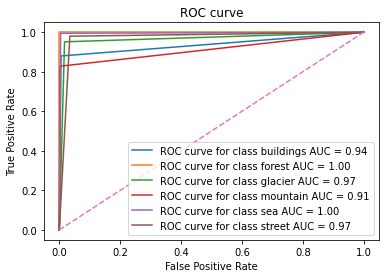

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
lab_plt = [(real_lab == i).astype(float) for i in range(6)]
outs_plt = [(all_pr == i).astype(float) for i in range(6)]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(lab_plt[i], outs_plt[i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.title('ROC curve')
for i in range(6):
  plt.plot(fpr[i], tpr[i], label = f'ROC curve for class {class_names[i]} AUC = {roc_auc[i]:.2f}' )
plt.legend(loc = 'best')
plt.plot([0,1], [0,1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Display precision, recall, f1-score metrics for each class (classification report)

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
print(classification_report(real_lab,all_pr, target_names=class_names))


              precision    recall  f1-score   support

   buildings       0.98      0.88      0.93       300
      forest       1.00      1.00      1.00       300
     glacier       0.85      0.95      0.90       124
    mountain       0.97      0.83      0.89       128
         sea       0.97      0.99      0.98       187
      street       0.89      0.98      0.93       300

    accuracy                           0.95      1339
   macro avg       0.94      0.94      0.94      1339
weighted avg       0.95      0.95      0.95      1339



## Visualize model prediction

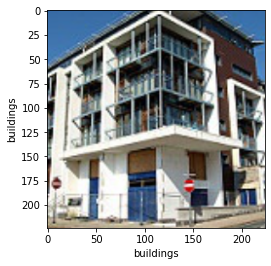

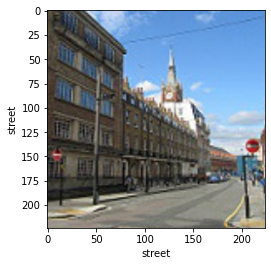

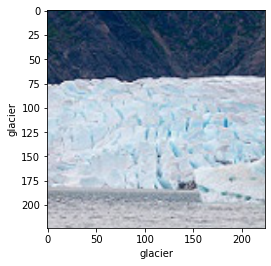

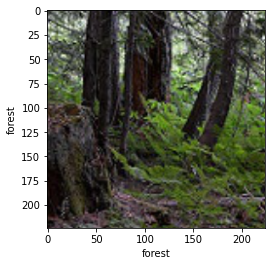

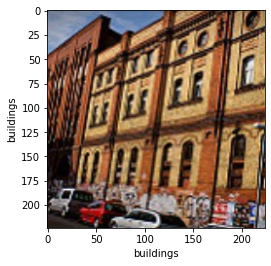

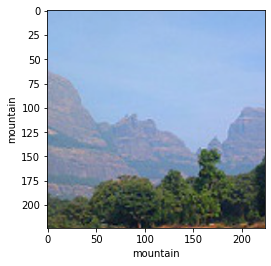

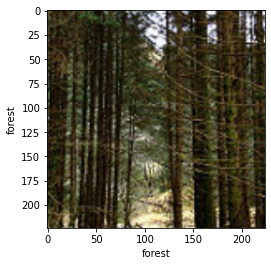

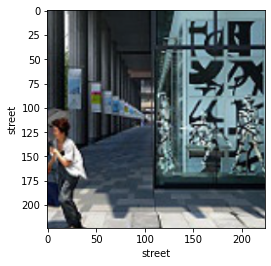

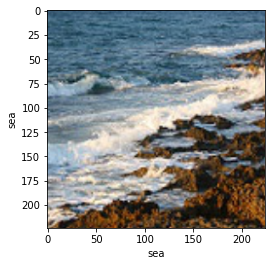

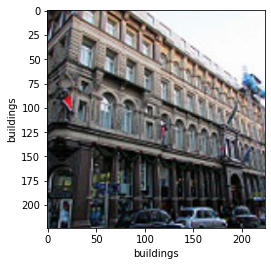

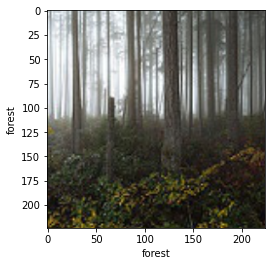

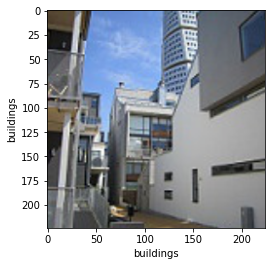

In [54]:
def plot_img(n):
  count = 0
  for img, lab in dataloaders['seg_test/seg_test']:
    count += 1 
    image = img 
    img = img.to(device)
    pred = model(img)
    _, pred = torch.max(pred, dim=1)
    for i in range(4):
      inp = torchvision.utils.make_grid(image[i]).numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)
      plt.ylabel(class_names[lab[i]])
      plt.xlabel(class_names[pred[i]])
      plt.show()
    if count == n:
      break

plot_img(3)